# JAX'd Finite GKP Simulations
7/27/24


## Setup

In [3]:
import dynamiqs as dq
import qutip as qt
import jax
from jax import jit
import ruff
import diffrax as dx
import jax.numpy as jnp
import jax.scipy.linalg as jla
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from dynamiqs import tensor
from IPython.display import display, Latex, Math

In [4]:
jla_sqrtm = jit(jla.sqrtm, device=jax.devices('cpu')[0])
@jax.jit
def jla_logm(b):
    I = jnp.eye(b.shape[0])
    res = jnp.zeros_like(b)
    ITERATIONS = 20
    for k in range(1, ITERATIONS):
        res += pow(-1, k+1) * jnp.linalg.matrix_power(b-I, k)/k
    return res

In [5]:
jnp.set_printoptions(precision=3)
def mat_print(array,tol=3):
    matrix = ''
    for row in array:
        try:
            for number in row:
                matrix += f'{np.round(number,tol)}&'
        except TypeError:
            matrix += f'{row}&'
        matrix = matrix[:-1] + r'\\'
    display(Math(r'\begin{bmatrix}'+matrix+r'\end{bmatrix}'))
def lat_print(val):
    display(Latex(val))

In [6]:
run_plots = False
run_tests = True

In [7]:

N = 170  # full computational
n = 25  # truncated for viewing / verification
hbar = 1
root2 = jnp.sqrt(2)
pi = jnp.pi
def tprint(mat,tol=3):
    mat_print(mat[:n, :n],tol=tol)

In [8]:

ket0 = dq.fock(2, 0)
ket1 = dq.fock(2, 1)
ketplus = (ket0 + ket1) / root2
ketminus = (ket0 - ket1) / root2

I_N = dq.eye(N)
a = dq.destroy(N)
a_dag = dq.create(N)
n_hat = dq.number(N)
x = (a + a_dag) / root2
p = -1j * (a - a_dag) / root2

In [9]:
def R_x(theta):
    return jla.expm(-1j*theta*dq.sigmax()/2)
def R_z(theta):
    return jla.expm(-1j*theta*dq.sigmaz()/2)
def com(ai,bi):
    return ai@bi - bi@ai
def anticom(ai,bi):
    return ai@bi + bi@ai
@jit
def sinm(ai):
    return -.5j*(jla.expm(1j*ai) - jla.expm(-1j*ai))
@jit
def sawtooth_fourier(ai,mi,ni=60):
    # a is the matrix
    # ni is the fourier truncation
    # mi is the half-width of the pulse
    sum = jnp.zeros_like(ai)
    arg_a = ai*2*jnp.pi/mi
    for k in range(1,ni+1):
        sum = sum + ((-1)**k)/k*sinm(arg_a*k)
    return -mi/jnp.pi*sum
def D(alpha_i):
    return jla.expm(alpha_i*a_dag - jnp.conj(alpha_i)*a)
def CD(beta_i):
    return jla.expm(tensor(beta_i*a_dag - jnp.conj(beta_i)*a,dq.sigmaz())/(2*root2))
def S(xi):
    return jla.expm(jnp.conj(xi)*(a@a)-xi*(a_dag@a_dag))

In [10]:
if run_plots:
  psi = dq.coherent(N, 0)
  dq.plot_wigner(psi)
  print(psi[:10])
  # displacement
  alpha_shift = 2 + 1j
  psi_shift = D(alpha_shift) @ psi
  print(psi_shift[:10])
  dq.plot_wigner(psi_shift)

  # controlled displacement
  psi_cd_shift_0 = CD(2*alpha_shift) @ tensor(psi,ket0)
  dq.plot_wigner(dq.ptrace(psi_cd_shift_0,0,(N,2)))
  psi_cd_shift_1 = CD(2*alpha_shift) @ tensor(psi,ket1)
  dq.plot_wigner(dq.ptrace(psi_cd_shift_1,0,(N,2)))
  psi_cd_shift_p = CD(2*alpha_shift) @ tensor(psi,ketminus)
  dq.plot_wigner(dq.ptrace(psi_cd_shift_p,0,(N,2)))

  # squeezing
  psi_squeeze_0 = S(.2j) @ psi
  dq.plot_wigner(psi_squeeze_0)
  

## Exact GKP Variables

In [11]:

l = 2 * jnp.sqrt(pi)
alpha = l * jnp.array([0, 1])
beta = l * jnp.array([-1, 0])
l_j = jnp.array(
    [
        jnp.sqrt(alpha[0] ** 2 + beta[0] ** 2),
        jnp.sqrt(alpha[1] ** 2 + beta[1] ** 2),
    ]
)
q_j = jnp.array(
    [
        alpha[0] * x + beta[0] * p,
        alpha[1] * x + beta[1] * p,
    ]
)
q_j_perp = jnp.array(
    [
        alpha[0] *p - beta[0] * x,
        alpha[1] * p - beta[1] * x,
    ]
)
omega_12 = alpha[0] * beta[1] - beta[0] * alpha[1]
T_j_0 = jnp.array(
    [
        jla.expm(1j * q_j[0]),
        jla.expm(1j * q_j[1]),
    ]
)
X_0 = jla.expm(1j*q_j[0]/2.)
Z_0 = jla.expm(1j*q_j[1]/2.)
Y_0 = jla.expm(1j*(q_j[0]+q_j[1])/2.)
x_j = jnp.array(
  [
    q_j[0]/l_j[0],
    q_j[1]/l_j[1]
  ]
)
x_j_perp = jnp.array(
  [
    q_j_perp[0]/l_j[0],
    q_j_perp[1]/l_j[1]
  ]
)

In [12]:

x_j_m = jnp.array(
  [
    sawtooth_fourier(x_j[0],2*pi/l_j[0]),
    sawtooth_fourier(x_j[1],2*pi/l_j[1])
  ]
)

### Verification of Variables

In [13]:
def jallclose(A,B,n=n,rtol=1e-6,atol=1e-6):
  return jnp.allclose(A[:n, :n],B[:n, :n],atol=atol,rtol=rtol)

In [26]:
lat_print("$[q_j,q_{j,perp}]= i (a_j^2 + b_j^2)$?")
com_0 = com(q_j[0],q_j_perp[0])
com_1 = com(q_j[1],q_j_perp[1])
print(jnp.all(jnp.isclose(jnp.diag(com_0)[:n],1j*(alpha[0]**2+beta[0]**2))))
print(jnp.all(jnp.isclose(jnp.diag(com_0)[:n],1j*(alpha[0]**2+beta[0]**2))))
lat_print("$[x_j,x_{j,perp}]= i$?")
com_0 = com(x_j[0],x_j_perp[0])
com_1 = com(x_j[1],x_j_perp[1])
print(jnp.all(jnp.isclose(jnp.diag(com_0)[:n],1j)))
print(jnp.all(jnp.isclose(jnp.diag(com_0)[:n],1j)))
lat_print("$T_{j,0} = e^{i q_j} = D((- b_j + i a_j) / \\sqrt{2} ) $?")
Dshift_0 = D((-beta[0]+1j*alpha[0])/root2)
Dshift_1 = D((-beta[1]+1j*alpha[1])/root2)
print(jallclose(T_j_0[0],Dshift_0))
print(jallclose(T_j_0[1],Dshift_1))
lat_print("$\\omega_{12} = 4 \\pi?$")
print(jnp.isclose(omega_12,4*pi))
lat_print("$[T_{1,0},T_{2,0}] = 0$?")
c0 = T_j_0[0]@T_j_0[1]
c1 = T_j_0[1]@T_j_0[0]
print(jallclose(c0,c1))
lat_print("$X_0 = \\sqrt{T_{1,0}} = e^{iq_1/2}$?")
exp_def_0 = jla.expm(1j*q_j[0]/2.0)
print(jallclose(X_0,exp_def_0))
lat_print("$Z_0 = \\sqrt{T_{2,0}} = e^{iq_2/2}$?")
exp_def_1 = jla.expm(1j*q_j[1]/2.0)
print(jallclose(Z_0,exp_def_1))
lat_print("$[X_0,T_{2,0}]=0$?")
X_T2_com = com(X_0,T_j_0[1])
print(jallclose(X_T2_com,np.zeros((n,n))))
lat_print("$[X_0,T_{1,0}]=0$?")
X_T1_com = com(X_0,T_j_0[0])
print(jallclose(X_T1_com,np.zeros((n,n))))
lat_print("$[Z_0,T_{1,0}]=0$?")
Z_T1_com = com(Z_0,T_j_0[0])
print(jallclose(Z_T1_com,np.zeros((n,n))))
lat_print("$[Z_0,T_{2,0}]=0$?")
Z_T2_com = com(Z_0,T_j_0[1])
print(jallclose(Z_T2_com,np.zeros((n,n))))
lat_print("$\\{Z_0,X_0\\}=0$?")
X_Z_anticom = anticom(X_0,Z_0)
print(jallclose(X_Z_anticom,np.zeros((n,n))))
lat_print("$Y_0 = -i Z_0 X_0$?")
prod = -1j*Z_0@X_0
print(jallclose(Y_0,prod))
# lat_print("$\\ln T_{j,0} = i l_j x_{j,[2\\pi/l_j]}$? ($\\pm .05$)")
# eps = .05
# log_T_0 = jla.logm(T_j_0[0])
# log_T_1 = jla.logm(T_j_0[1])
# rhs_0 = 1j*l_j[0]*x_j_m[0]
# rhs_1 = 1j*l_j[1]*x_j_m[1]
# print(jallclose(log_T_0,rhs_0,atol=eps))
# print(jallclose(log_T_1,rhs_1,atol=eps))

<IPython.core.display.Latex object>

TypeError: 'int' object is not subscriptable

## Finite GKP Variables

In [15]:
Delta = .2
c_Delta = jnp.cosh(Delta**2)
s_Delta = jnp.sinh(Delta**2)
t_Delta = jnp.tanh(Delta**2)
m_j = 2*pi/c_Delta/l_j
E_D = jla.expm(-Delta**2*n_hat)
E_D_plus = jla.expm(-Delta**2*(n_hat + I_N))
E_D_minus = jla.expm(-Delta**2*(n_hat - I_N))
E_D_inv = jla.inv(E_D)
c_n = .5*(E_D_minus@E_D_inv + E_D_plus@E_D_inv)
s_n = .5*(E_D_minus@E_D_inv - E_D_plus@E_D_inv)
T_j_E = jnp.array([E_D@T_j_0[0]@E_D_inv, E_D@T_j_0[1]@E_D_inv])
d_j_E = 1.0/root2*(x_j_m/jnp.sqrt(t_Delta) + 1j*x_j_perp*jnp.sqrt(t_Delta))
d_j_E_dag = np.array([jnp.conj(d_j.T) for d_j in d_j_E])
d_j_E_prod = np.array([d_j_E_dag[j]@d_j_E[j] for j in [0,1]])
X_E = jla.expm(.5*(1j*q_j[0]*c_Delta - q_j_perp[0]*s_Delta))
Z_E = jla.expm(.5*(1j*q_j[1]*c_Delta - q_j_perp[1]*s_Delta))
Y_E = 1j*Z_E@X_E

### Verification of Variables

In [16]:
lat_print("$ET_{i,0}E^{-1} = e^{EqE^{-1}}$?")
exp_form_0 = jla.expm(1j*E_D@(q_j[0]@E_D_inv))
print(jallclose(T_j_E[0],exp_form_0))
exp_form_1 = jla.expm(1j*E_D@(q_j[1]@E_D_inv))
print(jallclose(T_j_E[1],exp_form_1))
lat_print("$[T_{1,E},T_{2,E}] = 0$?")
com_val = com(T_j_E[0],T_j_E[1])
print(jallclose(com_val,jnp.zeros((n,n)),atol=1e-4))
lat_print("$T_{j,E}=e^{\\cosh(\\Delta^2)\\sinh(\\Delta^2)l_j^2/2}e^{-q_{j,perp}\\sinh(\\Delta^2)}e^{iq_j\\cosh(\\Delta^2)}$?")
exp_def_0 = np.exp(c_Delta*s_Delta*l_j[0]**2/2)*(jla.expm(-q_j_perp[0]*s_Delta)@jla.expm(1j*q_j[0]))
print(jallclose(T_j_E[0],exp_def_0,atol=.01))
exp_def_1 = np.exp(c_Delta*s_Delta*l_j[1]**2/2)*(jla.expm(-q_j_perp[1]*s_Delta)@jla.expm(1j*q_j[1]))
print(jallclose(T_j_E[1],exp_def_1,atol=.01))

<IPython.core.display.Latex object>

True
True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True
True


## Dynamics

### Setup

In [17]:
gamma = 1  # free parameter
gamma_j = jnp.array([gamma,gamma])
T = 10
epsilon_j = s_Delta*l_j
theta_j = jnp.angle(alpha+1j*beta)
Gamma_dt = t_Delta/4*c_Delta**2*l_j**2
dt = Gamma_dt[0]/gamma
t_f = dt*T
b_k = (dq.sigmax() + 1j*dq.sigmay())/2 # typo in paper
b_dag_k = dq.dag(b_k)
Nt = 100
t = jnp.linspace(0,1,Nt)

In [18]:
H_idle = dq.tensor(dq.eye(N),dq.eye(2))
H_E_n = jnp.sqrt(gamma)*(dq.tensor(d_j_E[0],b_dag_k) + dq.tensor(d_j_E_dag[0],b_k))
U_n = jla.expm(-1j*jnp.sqrt(dt)*H_E_n)
U_n_dag = dq.dag(U_n)
Number_rq = dq.tensor(dq.number(N),dq.eye(2))
a_rq = dq.tensor(a,dq.eye(2))

### Markov Verification

In [19]:

lat_print("$[b_n,b_n^{\\dagger}] = \\sigma_z$?")
print(jallclose(com(b_k,b_dag_k),dq.sigmaz()))
lat_print("$U_n$ unitary?")
print(jnp.isclose(1,jnp.abs(jnp.linalg.det(U_n))))
lat_print("$U_n^{\\dagger}$ unitary?")
print(jnp.isclose(1,jnp.abs(jnp.linalg.det(U_n_dag))))
lat_print("$\\Gamma_j\\delta t=t_{\\Delta}c_{\\Delta}^2l_j^2/4$?")
print(jnp.allclose(gamma_j*dt,t_Delta/4*c_Delta**2*l_j**2))

<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


<IPython.core.display.Latex object>

True


### Open Dynamics

In [20]:
alpha = 0
psi_0 = dq.tensor(dq.coherent(N,alpha),dq.fock(2,0))
rho_0 = dq.todm(psi_0)
times = jnp.linspace(0,6,100)
dissipator_x = dq.tensor(gamma*d_j_E[0],dq.eye(2))
dissipator_p = dq.tensor(gamma*d_j_E[1],dq.eye(2))

In [21]:

me_open_res = dq.mesolve(
  H=H_idle,
  jump_ops=[dissipator_x,dissipator_p],
  rho0=rho_0,
  tsave=times,
  exp_ops=[Number_rq,a_rq]
)
rho_t = me_open_res.states
rho_r_t = dq.ptrace(rho_t,0,(N,2))
n_t = jnp.real(me_open_res.expects[0])
a_t = me_open_res.expects[1]


|██████████| 100.0% ◆ elapsed 566.73ms ◆ remaining 0.00ms  


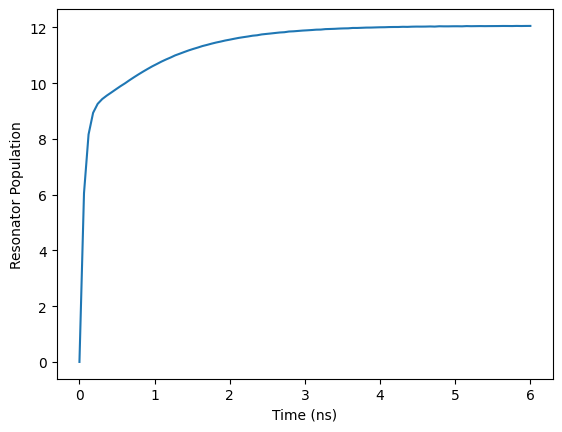

In [22]:
plt.xlabel("Time (ns)")
plt.ylabel("Resonator Population")
plt.plot(times,n_t)
plt.show()

In [23]:
# dq.plot_wigner_gif(
#   rho_r_t,
#   gif_duration=10,
#   fps=25,
#   xmax=4,
#   ymax=4,
#   npixels=200,
#   filename="manifold_stabilizing.gif"
# )

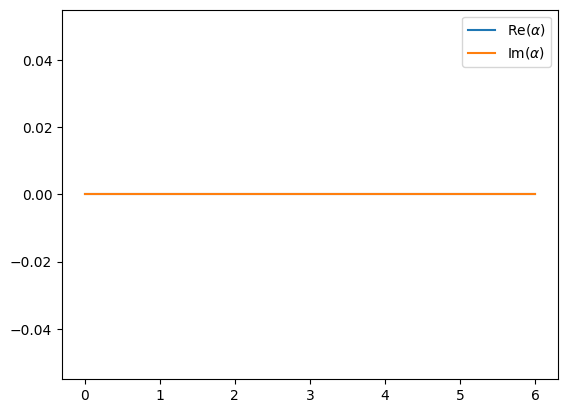

In [24]:
plt.plot(times,jnp.real(a_t),label=r"$\text{Re}(\alpha)$")
plt.plot(times,jnp.imag(a_t),label=r"$\text{Im}(\alpha)$")
plt.legend()
plt.show()

### Intuition for Manifold Actions


#### Non Commuting Shifts

In [25]:
rho_T = rho_r_t[-1]
dq.plot_wigner(rho_T)

AttributeError: module 'dynamiqs' has no attribute 'plot_wigner'

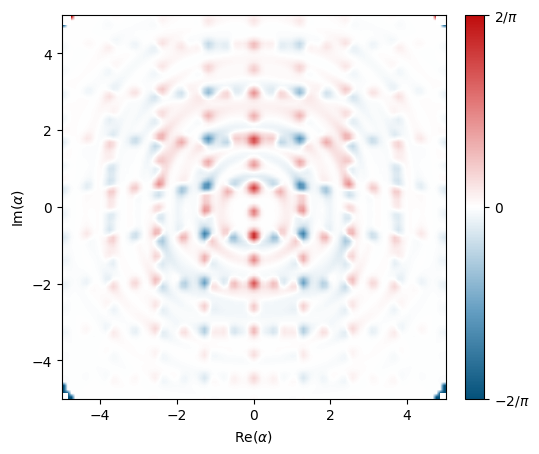

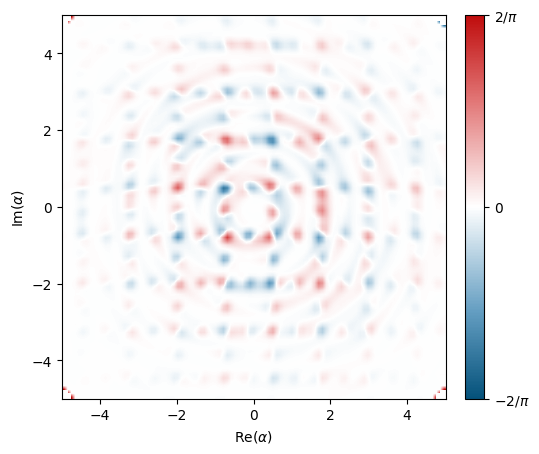

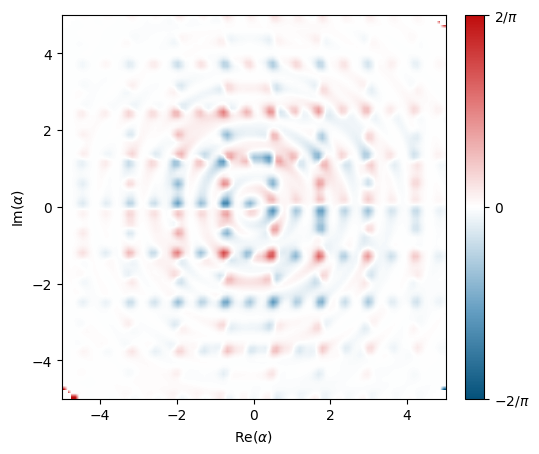

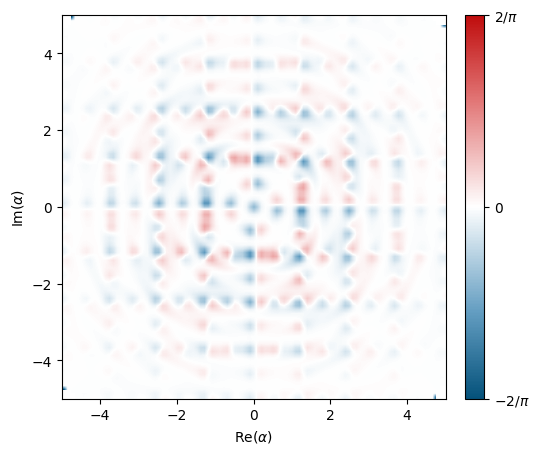

In [ ]:
alpha_shift = 1j
shift_cycle = [1j, 1, -1j, -1]
rho_s = rho_T
for shift in shift_cycle:
  rho_s = D(shift) @ rho_s
  dq.plot_wigner(rho_s)

#### Shift + Restabilize Visualization

Population: (12.05630874633789+0j)


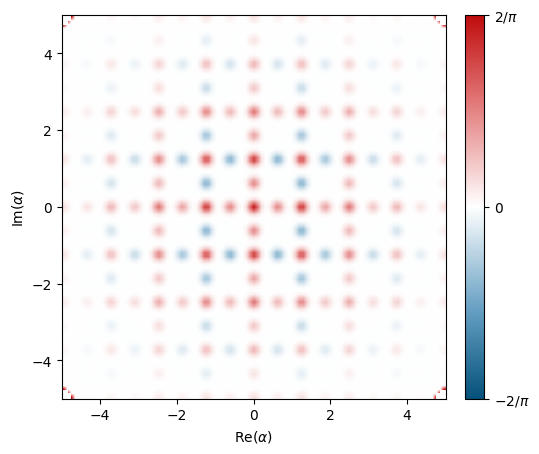

In [ ]:
dq.plot_wigner(rho_T)
print(f"Population: {dq.expect(n_hat,rho_T)}")

Population (shifted): (11.301862716674805+0j)


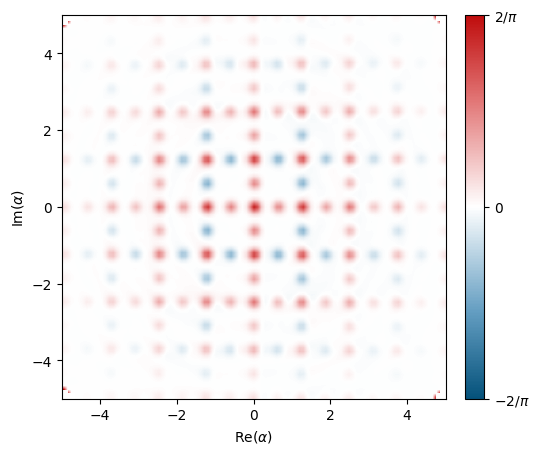

In [ ]:
displacement_shift = .05
rho_shifted = D(displacement_shift) @ rho_T
print(f"Population (shifted): {dq.expect(n_hat,rho_shifted)}")
dq.plot_wigner(rho_shifted)


In [ ]:
rho_0_shift = dq.tensor(rho_shifted,dq.fock_dm(2,0))
shift_times = jnp.linspace(0,5,100)
restabilize_res = dq.mesolve(
  H=H_idle,
  jump_ops=[dissipator_x,dissipator_p],
  rho0=rho_0_shift,
  tsave=shift_times,
  exp_ops=[Number_rq,]
)
rho_shifted_t = dq.ptrace(restabilize_res.states,0,(N,2))
n_t_restabilizing = restabilize_res.expects[0]

|██████████| 100.0% ◆ elapsed 1.04s ◆ remaining 0.00ms     


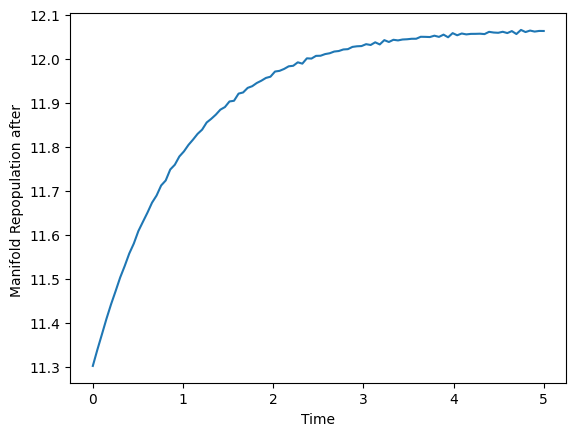

In [ ]:
plt.plot(shift_times,jnp.real(n_t_restabilizing))
plt.xlabel("Time")
plt.ylabel("Manifold Repopulation after ")
plt.show()

100%|██████████| 125/125 [00:12<00:00, 10.19it/s]


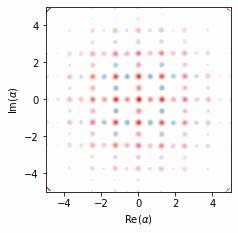

In [ ]:
dq.plot_wigner_gif(
  states=rho_shifted_t,
  gif_duration=5,
  fps=25,
  npixels=200,
  filename="shift_restabilize.gif"
)

#### $T_j$, $d_j$ Modes

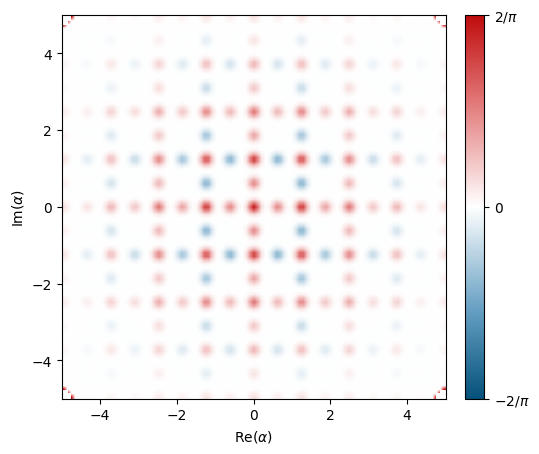

In [ ]:
dq.plot_wigner(rho_T)

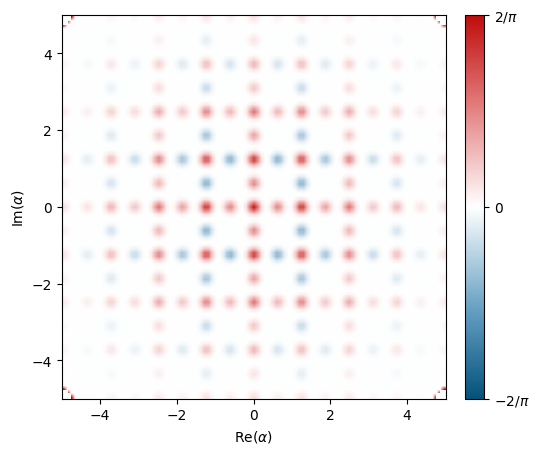

In [ ]:
rho_T_j = T_j_E[0] @ rho_T # does not nothing as expected
dq.plot_wigner(rho_T_j)

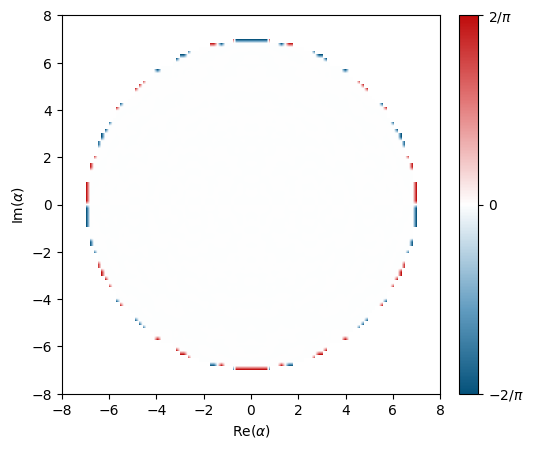

In [ ]:
rho_d_j = d_j_E[0] @ rho_T # kills as expected
dq.plot_wigner(
  state=rho_d_j,
  xmax=8,
  ymax=8
)

## Control

In [ ]:
from jaxtyping import PyTree, ArrayLike, Shaped, Array
from typing import TypeVar, TypeAlias, Union, Callable, Any
FloatScalarLike = Union[float, Array, np.ndarray]
IntScalarLike = Union[int, Array, np.ndarray]
RealScalarLike = Union[FloatScalarLike, IntScalarLike]

In [ ]:
class AncillaResetSolver(dx.AbstractSolver):
  term_structure = dx.AbstractTerm
  interpolation_cls = dx.LocalLinearInterpolation

  def order(self, terms):
    return 1
  def init(self, terms, t0, t1, y0, args):
    return None
  
  def step(self, terms, t0, t1, y0, args, solver_state, made_jump):
    del solver_state, made_jump
    
    

### Sharpen-Trim, BsB, sBs